# AMS516 Homework 1. Continuous-time stochastic linear quadratic regulators (LQR)

## Juan Perez Osorio

## **1. An infinite-horizon discounted stochastic LQR problem**

Consider the following continuous-time dynamics:

$$dx_t = (Ax_t + Bu_t)dt + Gdw_t$$

where:

* $x_t \in \mathbb{R}^n$ is the state vector
* $u_t \in \mathbb{R}^m$ is the control input
* $w_t$ is a standard $r$-dimensional Wiener process
* $G \in \mathbb{R}^{n \times r}$ is the noise gain matrix

The discounted quadratic cost is given by:

$$J(x_0; u) = \mathbb{E}\left[ \int_0^\infty e^{-\rho t}(x_t^\intercal Q x_t + u_t^\intercal R u_t) dt \right]$$

with:

* Discount rate $\rho > 0$
* $Q \geq 0$ (positive semidefinite)
* $R \geq 0$ (positive semidefinite)

The goal is to find optimal feedback control $u_t = -Kx_t$ minimizing $J$.

The Hamilton-Jacobi-Bellman (HJB) equation for the discounted cost is:

$$\rho V(x) = \min_u \left\{x^\intercal Q x + u^\intercal R u + \nabla V(x)^\intercal (Ax + Bu) + \frac{1}{2} \text{tr}(GG^\intercal \nabla^2 V) \right\}$$

The value function $V(x)$ and the optimal control $u$ have the form:

$$V(x) = x^\intercal P x + c$$
$$u = -R^{-1} B^\intercal P x$$

Moreover, $P$ satisfies the discounted continuous algebraic Riccati equation (CARE)

$$A^\intercal P + PA - P B R^{-1} B^\intercal P + Q - \rho P = 0$$

and $c$ is given by:

$$c = \frac{\operatorname{tr}(G G^T P)}{\rho}.$$

Consider the problem with the following parameters:

$$
\rho = 0.1, \quad A = \begin{bmatrix} 0 & 1 \\ -2 & -3 \end{bmatrix}, \quad B = \begin{bmatrix} 0 \\ 1 \end{bmatrix}, \quad G = \begin{bmatrix} 0.1 & 0 \\ 0 & 0.1 \end{bmatrix}, \quad Q = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix}, \quad R = [1].
$$

**(a).** Use the analytical result above to compute the value function $V(x)$ and optimal control $u$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_continuous_are, solve_lyapunov, eigvals, norm, solve_continuous_lyapunov

In [2]:
rho: float = 0.1

A = np.array([[0, 1], [-2, -3]])
B = np.array([[0], [1]])
G = np.array([[0.1, 0], [0, 0.1]])
Q = np.array([[1, 0], [0, 1]])
R = np.array([[1]])

We can see that when checking the library for the function ``solve_continuos_are``, we found that it solves the continuos-time algebraic Riccati equation (CARE):

$$
\begin{equation}
A^H X + XA - X B R^{-1} B^H X + Q = 0
\end{equation}
$$

But we now that $P = X$ satisfies the discounted continuous algebraic Riccati equation (CARE):

$$
\begin{equation*}
A^\intercal P + PA - P B R^{-1} B^\intercal P + Q - \rho P = 0
\end{equation*}
$$

So we need to turn our last equation into the form of (1) so we can apply the scipy method. To do so we manipulate the expression in the following way

$$
\begin{split}
A^\intercal P + PA - P B R^{-1} B^\intercal P + Q - \rho P &= 0 \\
A^\intercal P + PA - P B R^{-1} B^\intercal P + Q  &= \rho P\\
A^\intercal P + PA - P B R^{-1} B^\intercal P + Q  &= \frac{1}{2}\rho (IP + PI)\\
\left(A^\intercal P - \frac{1}{2} \rho IP \right) + \left(PA - \frac{1}{2} \rho PI \right) - P B R^{-1} B^\intercal P + Q  &= 0 \\
\left(A^\intercal - \frac{1}{2} \rho I \right)P + P\left(A - \frac{1}{2} \rho I \right) - PBR^{-1} B^\intercal P + Q  &= 0 \\
\end{split}
$$

Letting $A_{\text{disc}} = A - \frac{1}{2} \rho I$, we can see that the previous equation reduces to 

$$
A^{\intercal}_{\text{disc}}P + PA_{\text{disc}} - PBR^{-1} B^\intercal P + Q  = 0
$$

we can see that our final expression is now in the same form as (1) and hence, we can apply the scipy method

In [3]:
I = np.identity(A.shape[0])

# Modify A so that we can use the solve_continuos_are method from scipy
A_discounted = A - (1/2) * rho * I

# Solve continuous-time algebraic Riccati equation (CARE)
P = solve_continuous_are(a = A_discounted, b = B, q = Q, r = R)

The optimal gain matrix $K$ is defined to be

$$K = R^{-1} B^\intercal P$$

so we have that 

$$u = -Kx$$

In [4]:
# Optimal gain matrix
K = np.linalg.inv(R) @ B.T @ P

Replacing this in the time dynamics we have 

$$
\begin{split}
dx_t &= (Ax_t + Bu_t)dt + Gdw_t \\
     &= (Ax_t - BK x_t)dt + Gdw_t \\
     &= (A- BK)x_tdt + Gdw_t \\
     &= (A_{\text{closed}})x_tdt + Gdw_t
\end{split}
$$

Where we define $A_{\text{closed}}$ to be the closed loop matrix and it describes the dynamics of a system with feedback control law, i.e., the closed-loop system is obtained by substituting the optimal control $u$ into the dynamics of the system.

A nice way to checking the stability of the system is by checking the eigenvalues of the closed loop matrix

> we can summarize how the two-dimensional linear dynamical system's stability depends on  $\operatorname{Tr}(A)$ and  $det(A)$ in a simple diagram as shown

![stability](./images/stability.png)

Hence we have to check that all the eigenvalues of the closed loop matrix are negative so that our system is stable; we do this procedure to confirm that the solution $P$ from the (discounted) CARE produces a stabilizing controller $K$. If any eigenvalue had a positive real part, the controller would be useless as the state would blow up.

In [5]:
# Stability analysis
A_cl = A - B @ K
eig_A_cl = eigvals(A_cl)

print("\nEigenvalues of A_cl:")
print(eig_A_cl)

# Check if all real parts are negative (system is stable)
is_stable = np.all(np.real(eig_A_cl) < 0)
print(f"Is the closed-loop system stable? {is_stable}")


Eigenvalues of A_cl:
[-0.98838969+0.j -2.23620796+0.j]
Is the closed-loop system stable? True


Let’s define $X_t = \mathbb{E}[x_t x_t^T]$. This is the covariance matrix of the state at time $t$. Its evolution is governed by the SDE. Itô's Lemma tells us how to find the differential $d(x_t x_t^T)$.

$$
\begin{split}
d(x_t x_t^\intercal) =& \left[d(x_t)\right]x^{\intercal}_{t} + x_t \left[d(x^{\intercal}_{t})\right] + \left[d(x_t)\right]\left[d(x^{\intercal}_{t})\right] \\

=& \left[A_{\text{closed}}x_tdt + Gdw_t\right]x^{\intercal}_{t} + x_t \left[(A_{\text{closed}}x_tdt + Gdw_t)^\intercal\right] + \left[d(x_t)\right]\left[d(x^{\intercal}_{t})\right] \\

\end{split}
$$

but we know that 

$$[d(x_t)][d(x_t)]^\intercal = (G dw_t)(G dw_t)^\intercal = G (dw_t dw_t^\intercal) G^\intercal = G (I dt) G^\intercal = G G^\intercal dt$$

Hence, we have 

$$ d(x_t x_t^\intercal) = \left(A_{\text{closed}}x_tdt + Gdw_t\right)x^{\intercal}_{t} + x_t \left(A_{\text{closed}}x_tdt + Gdw_t\right)^\intercal + G G^\intercal dt$$

We want an equation for $dX_t = d(\mathbb{E}[x_t x_t^\intercal]) = \mathbb{E}[d(x_t x_t^\intercal)]$.

* $\mathbb{E}[G dw_t x_t^\intercal] = 0$ and $\mathbb{E}[x_t dw_t^\intercal G^\intercal] = 0$ because the current state $x_t$ is uncorrelated with the future noise $dw_t$.

* $\mathbb{E}[A_{cl} x_t x_t^\intercal dt] = A_{cl} \mathbb{E}[x_t x_t^\intercal] dt = A_{cl} X_t dt$

* $\mathbb{E}[x_t x_t^\intercal A_{cl}^\intercal dt] = X_t A_{cl}^\intercal dt$

* $\mathbb{E}[G G^\intercal dt] = G G^\intercal dt$

Hence we have that

$$ dX_t = \mathbb{E}[d(x_t x_t^\intercal)] = A_{\text{closed}}X_tdt + X_{t}A_{\text{closed}}^{\intercal}dt + GG^\intercal dt$$

$$ \frac{dX_t}{dt} = A_{\text{closed}}X_t + X_{t}A_{\text{closed}}^{\intercal} + GG^\intercal$$

At steady-state, the system's statistical properties don't change anymore. This means the covariance matrix $X_t$ settles to a constant matrix $\Sigma$, so its derivative becomes zero $dX_t / dt = 0$. Hence, at steady state we have that

$$
A_{\text{closed}}\Sigma + \Sigma A_{\text{closed}}^{\intercal} + GG^\intercal = 0
$$ 

This is the famous **Lyapunov equation**. To solve it we use the ``solve_lyapunov`` from the scipy library

In [6]:
# Steady state covariance
GGt = G @ G.T

# Solves the continuous Lyapunov equation AX + XA^H = Q
S = solve_lyapunov(A_cl, -GGt)

# The discounted value constants are given by
c = np.trace(GGt @ P) / rho

# Example: initial state and optimal discounted cost
x0 = np.array([1.0, 0])
J0 = x0.T @ P @ x0 + c

print('rho = ', rho)
print('P = \n', P)
print('K = \n', K)
print('Sigma = \n', S)
print('Value constant c = ', c)
print('J(x0) = ', J0)

rho =  0.1
P = 
 [[1.14817499 0.2102449 ]
 [0.2102449  0.22459765]]
K = 
 [[0.2102449  0.22459765]]
Sigma = 
 [[ 0.00954679 -0.005     ]
 [-0.005       0.00497774]]
Value constant c =  0.13727726484530767
J(x0) =  1.2854522598310418


**(b).** Show that the optimal control $u$ in (3) is given by $u^∗ = −R^{−1}B^\intercal \nabla V$ . Plug $u^∗$ into (3), we obtain a differential equation of $V$. Use the PINN method to solve the obtained equation for $V$ and $u$. Denote your solution by $\hat{V}$ and $\hat{u}$.

We know that the HJB equation for the discounted cost is 

$$\rho V(x) = \min_u \left\{x^\intercal Q x + u^\intercal R u + \nabla V(x)^\intercal (Ax + Bu) + \frac{1}{2} \text{tr}(GG^\intercal \nabla^2 V) \right\}$$

as we can see, not all terms inside the minimization objective contain $u$, hence, we can split this in two parts

$$\rho V(x) = \min_u \left\{u^\intercal R u + \nabla V(x)^\intercal Bu \right\} + \left[x^\intercal Q x + \nabla V(x)^\intercal Ax + \frac{1}{2} \text{tr}(GG^\intercal \nabla^2 V) \right]$$

Since we want to find the $u$ that minimizes the expression, we can focus solely on the part that depends on $u$, let's define this part by $f$

$$ f(u) = u^\intercal R u + \nabla V(x)^\intercal Bu $$

To find the minimum of the function $g(u)$ with respect to the vector $u$, we take its gradient (derivative with respect to $u$) and set it equal to zero. Computing the Gradient $\nabla_u f(u)$ we obtain that 

$$\nabla_u f(u) = (R + R^\intercal)u + B^\intercal \nabla V(x)$$

But since $R$ is symmetric we have that

$$\nabla_u f(u) = 2Ru + B^\intercal \nabla V(x) = 0$$
$$2Ru = -B^\intercal \nabla V(x)$$
$$u^* = -\frac{1}{2}R^{-1}B^\intercal \nabla V(x)$$

Plugging this into the HJB equation for the discounted cost we can notice that

$$\nabla V(x)^\intercal B u^* = \nabla V(x)^T B (-R^{-1}B^T \nabla V) = -\frac{1}{2}\nabla V^\intercal B R^{-1} B^\intercal \nabla V$$

$$
\begin{split}
{u^*}^\intercal R u^* &= \left(-\frac{1}{2}R^{-1}B^\intercal \nabla V\right)^\intercal R \left(-\frac{1}{2}R^{-1}B^\intercal \nabla V\right) \\
                      &= \frac{1}{4}\nabla V^\intercal B (R^{-1})^\intercal RR^{-1}B^\intercal \nabla V \\
                      &= \frac{1}{4}\nabla V^\intercal B R^{-1} B^\intercal \nabla V \\
\end{split}
$$ 

Now we plug these back in. Notice that 

$$(u^*)^\intercal R u^* + \nabla V(x)^\intercal B u^* = \frac{1}{4}\nabla V^\intercal B R^{-1} B^\intercal \nabla V - \frac{1}{2}\nabla V^\intercal B R^{-1} B^\intercal \nabla V = - \frac{1}{4}\nabla V^\intercal B R^{-1} B^\intercal \nabla V$$

Therefore we have that the HJB equation for the discounted cost takes the form

$$\rho V(x) = x^\intercal Q x + \nabla V(x)^\intercal Ax - \frac{1}{4}\nabla V^\intercal B R^{-1} B^\intercal \nabla V + \frac{1}{2} \text{tr}(GG^\intercal \nabla^2 V)$$

So, we can define our loss function to be

$$L_{\operatorname{physics}} = \left| \rho V(x) - x^\intercal Q x - \nabla V(x)^\intercal Ax + \frac{1}{4}\nabla V(x)^\intercal B R^{-1} B^\intercal \nabla V(x) - \frac{1}{2} \text{tr}(GG^\intercal \nabla^2 V(x))\right|$$

Now we're going to set up the PINN in torch

1. Import required libraries

In [7]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import matplotlib as mpl

In [8]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

In [9]:
# Set device: allows us to specify whether computations should occur on the CPU or GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Test to see where the tensor was created
tensor_on_device = torch.rand(5, device=device)
print(f"Tensor created directly on {tensor_on_device.device}")

# Convert the system parameters to torch tensors
rho: float = 0.1
A = torch.tensor([[0.0, 1.0], [-2.0, -3.0]], device = device)
B = torch.tensor([[0.0], [1.0]], device = device)
G = torch.tensor([[0.1, 0.0], [0.0, 0.1]], device = device)
Q = torch.tensor([[1.0, 0.0], [0.0, 1.0]], device = device)
R = torch.tensor([[1.0]], device = device)
R_inv = torch.linalg.inv(R)

# Pre-compute useful matrices
B_Rinv_BT = B @ R_inv @ B.T
GGt = G @ G.T

Tensor created directly on cpu


In [10]:
torch.cuda.is_available()

False

Neural network definition:

In [11]:
class ValueNetwork(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=64, out_dim=1, num_layers=3):
        super(ValueNetwork, self).__init__()

        # Define the input layers
        layers = []
        # Input layer
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.Tanh())

        # Hidden layers
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.Tanh())

        # Output layer (value function V(x))
        layers.append(nn.Linear(hidden_dim, out_dim))

        # Define the sequential network 
        self.network = nn.Sequential(*layers)

    # Define the mathematical transformation from input to output
    def forward(self, x):
        return self.network(x)

PINN Loss Function

In [12]:
class HJB_PINN:
    def __init__(self, model, A, B, Q, R, R_inv, GGt, rho):
        self.model = model
        self.A = A
        self.B = B
        self.Q = Q
        self.R = R
        self.R_inv = R_inv
        self.GGt = GGt
        self.rho = rho
        self.B_Rinv_BT = B @ R_inv @ B.T

    def compute_gradients(self, x):
        '''Compute V, ∇V, and ∇²V using automatic differentiation'''
        x.requires_grad_(True)

        # Compute V(x)
        V = self.model(x)

        # Compute ∇V(x) (gradient of V with respect to x)
        grad_V = torch.autograd.grad(V.sum(), x, create_graph=True)[0]
        
        # Compute ∇²V (Hessian)
        hessian_V = []
        for i in range(x.shape[1]):
            grad_V_i = grad_V[:, i]    # i-th component of the gradient
            hessian_i = torch.autograd.grad(grad_V_i.sum(), x, create_graph=True)[0]
            hessian_V.append(hessian_i.unsqueeze(1))

        # Stack to get full Hessian: [batch_size, n, n]
        hessian_V = torch.cat(hessian_V, dim=1)

        return V, grad_V, hessian_V
    
    def physics_loss(self, x):
        '''Compute the HJB PDE residual'''
        V, grad_V, hessian_V = self.compute_gradients(x)

        # HJB PDE terms
        term1 = torch.einsum('bi,ij,bj->b', x, self.Q, x).unsqueeze(1)  # xᵀQx
        term2 = torch.einsum('bi,ij,bj->b', grad_V, self.A, x).unsqueeze(1)  # ∇VᵀAx

        # GGᵀ∇²V for each sample in batch
        GGt_hessian = torch.einsum('ij,bjk->bik', self.GGt, hessian_V)

        # Sum of diagonal elements for each batch (Trace)
        trace_GGt_hessian = torch.einsum('bii->b', GGt_hessian).unsqueeze(1)
        term3 = 0.5 * trace_GGt_hessian  # ½tr(GGᵀ∇²V)

        # Nonlinear term: -1/4(∇Vᵀ B R⁻¹ Bᵀ ∇V)
        quad_form = torch.einsum('bi,ij,bj->b', grad_V, self.B_Rinv_BT, grad_V).unsqueeze(1)
        term4 = -0.25 * quad_form
        
        # PDE residual: ρV - [xᵀQx + ∇VᵀAx + ½tr(GGᵀ∇²V) - ¼(∇Vᵀ B R⁻¹ Bᵀ ∇V)]
        pde_residual = self.rho * V - (term1 + term2 + term3 + term4)
    
        return torch.mean(pde_residual**2)

Training setup and data generation

In [13]:
# Generate 1000 points on the domain. From [-2, 2]
def generate_training_data(num_domain=1000, x_range=(-2, 2)):
    '''Generate collocation points for training'''
    # Domain points (random sampling) [Generates random numbers between -2 and 2]
    x_domain = torch.rand(num_domain, 2) * (x_range[1] - x_range[0]) + x_range[0]

    return x_domain.to(device)

# Initialize the model and trainer
model = ValueNetwork().to(device)
pinn = HJB_PINN(model, A, B, Q, R, R_inv, GGt, rho)

# Generate the training data
x_domain = generate_training_data()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=500, factor=0.5)

Training loop

In [14]:
def train_pinn(pinn, x_domain, epochs = 5000, print_every = 500):

    losses = []

    for epoch in range(epochs + 1):
        optimizer.zero_grad()

        # Physics loss (PDE residual)
        loss_pde = pinn.physics_loss(x_domain)

        # Total loss
        total_loss = loss_pde
        
        total_loss.backward()
        optimizer.step()
        scheduler.step(total_loss)

        losses.append(total_loss.item())

        if epoch % print_every == 0:
            print(f'Epoch {epoch}, Loss: {total_loss.item():.6f}, PDE: {loss_pde.item():.6f}')
    
    return losses

# Train the model
print("Start training...")
losses = train_pinn(pinn, x_domain, epochs=5000)

Start training...
Epoch 0, Loss: 10.168041, PDE: 10.168041


c:\Users\JUANJO\Documents\GitHub\ams-516\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:1340: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:836.)
  current = float(metrics)


Epoch 500, Loss: 0.022697, PDE: 0.022697
Epoch 1000, Loss: 0.005616, PDE: 0.005616
Epoch 1500, Loss: 0.002319, PDE: 0.002319
Epoch 2000, Loss: 0.001207, PDE: 0.001207
Epoch 2500, Loss: 0.000948, PDE: 0.000948
Epoch 3000, Loss: 0.000389, PDE: 0.000389
Epoch 3500, Loss: 0.000245, PDE: 0.000245
Epoch 4000, Loss: 0.000151, PDE: 0.000151
Epoch 4500, Loss: 0.000107, PDE: 0.000107
Epoch 5000, Loss: 0.000076, PDE: 0.000076


Visualization and analysis

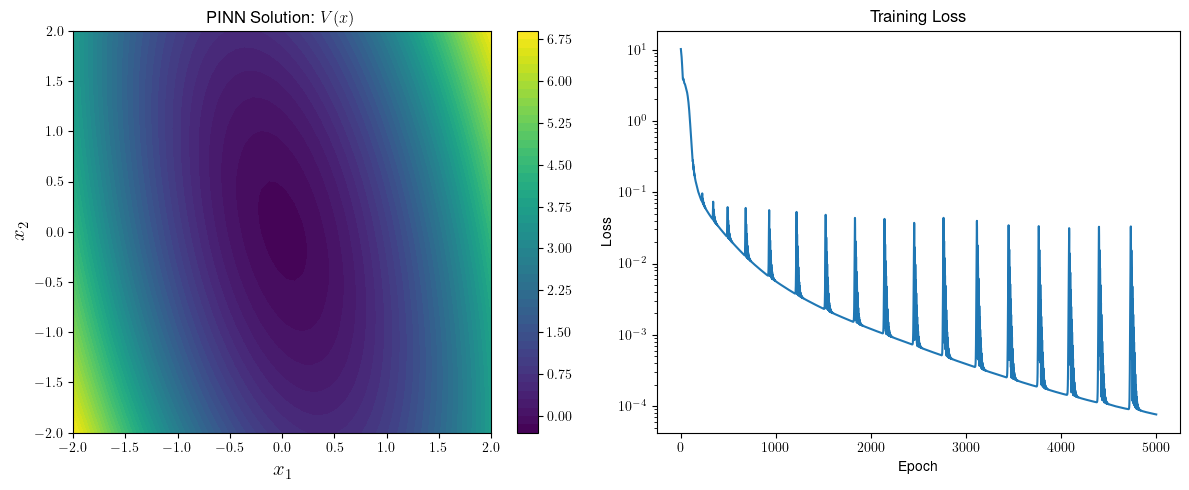

In [15]:
def analyze_solution(model):
    """Compare PINN solution with analytical solution"""
    # Create test grid
    x1 = torch.linspace(-2, 2, 50)
    x2 = torch.linspace(-2, 2, 50)
    X1, X2 = torch.meshgrid(x1, x2, indexing='ij')
    # Define pairs of coordinated in the grid
    x_test = torch.stack([X1.ravel(), X2.ravel()], dim=1).to(device)
    
    # PINN prediction
    with torch.no_grad():
        V_pinn = model(x_test).cpu().numpy()
    
    # Reshape for plotting
    V_pinn_grid = V_pinn.reshape(50, 50)
    
    # Plot results
    plt.figure(figsize=(12, 5), dpi=100)
    
    plt.subplot(1, 2, 1)
    contour = plt.contourf(X1.numpy(), X2.numpy(), V_pinn_grid, levels=50)
    plt.colorbar(contour)
    plt.xlabel(r'$x_1$', fontsize=15)
    plt.ylabel(r'$x_2$', fontsize=15)
    plt.title(r'PINN Solution: $V(x)$')
    
    plt.subplot(1, 2, 2)
    plt.semilogy(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    
    plt.tight_layout()
    plt.show()
    
    return V_pinn_grid

# Analyze the trained model
V_pinn = analyze_solution(model)

**(c).** Compare your results in (a) and (b). Report the $\ell_1$ norm of the absolute error $e_1 := \|V(x) - \hat{V}(x)\|_1$ and the relative error $e_2 := \|V(x)/\hat{V}(x) - 1\|_1$ for $V$.

In [16]:
def compare_solutions(model, P_analytical, c_analytical, K_analytical, x_range=(-2, 2), grid_points=50):
    """Compare PINN solution with analytical solution"""
    
    # Create test grid
    x1 = np.linspace(x_range[0], x_range[1], grid_points)
    x2 = np.linspace(x_range[0], x_range[1], grid_points)
    
    # Make a grid of X1 and X2 coordinates
    X1, X2 = np.meshgrid(x1, x2, indexing='ij')
    # Merge both grids in coordinate pairs, shape = (2500, 2) = (gridpoints², 2)
    x_test_np = np.stack([X1.ravel(), X2.ravel()], axis=1)
    x_test_torch = torch.tensor(x_test_np, dtype=torch.float32, device=device)
    
    # Analytical solutions
    V_analytical = np.array([x.T @ P_analytical @ x + c_analytical for x in x_test_np])
    u_analytical = -K_analytical @ x_test_np.T  # u = -Kx
    
    # PINN predictions
    with torch.no_grad():
        V_pinn = model(x_test_torch).cpu().numpy().flatten()
    
    # Compute PINN control (u = -½R⁻¹Bᵀ∇V)
    u_pinn = []
    grad_V_pinn = []
    for x in x_test_np:
        x_tensor = torch.tensor(x, dtype=torch.float32, device=device).unsqueeze(0)
        x_tensor.requires_grad_(True)
        V = model(x_tensor)
        grad_V = torch.autograd.grad(V, x_tensor, create_graph=False)[0]
        u = -0.5 * (R_inv @ B.T @ grad_V.T).T
        u_pinn.append(u.cpu().numpy().flatten())
        grad_V_pinn.append(grad_V.cpu().numpy().flatten())
    
    u_pinn = np.array(u_pinn).T  # Shape: (1, n_points)
    grad_V_pinn = np.array(grad_V_pinn)
    
    # Reshape for plotting
    V_analytical_grid = V_analytical.reshape(grid_points, grid_points)
    V_pinn_grid = V_pinn.reshape(grid_points, grid_points)
    V_error_grid = np.abs(V_pinn_grid - V_analytical_grid)
    
    u_analytical_grid = u_analytical.reshape(1, grid_points, grid_points)
    u_pinn_grid = u_pinn.reshape(1, grid_points, grid_points)
    u_error_grid = np.abs(u_pinn_grid - u_analytical_grid)
    
    return {
        'x1': X1, 'x2': X2,
        'V_analytical': V_analytical_grid, 'V_pinn': V_pinn_grid, 'V_error': V_error_grid,
        'u_analytical': u_analytical_grid, 'u_pinn': u_pinn_grid, 'u_error': u_error_grid,
        'grad_V_pinn': grad_V_pinn
    }

def plot_comparison(comparison_results):
    """Create comprehensive comparison plots"""
    
    X1, X2 = comparison_results['x1'], comparison_results['x2']
    
    fig = plt.figure(figsize=(20, 15), dpi=300)
    
    # 1. Value Function Comparison
    
    # Analytical solution for V
    plt.subplot(3, 4, 1)
    contour = plt.contourf(X1, X2, comparison_results['V_analytical'], levels=50)
    plt.colorbar(contour)
    plt.xlabel(r'$x_1$', fontsize=15)
    plt.ylabel(r'$x_2$', fontsize=15)
    plt.title(r'Analytical $V(x)$')
    
    # PINN solution for V
    plt.subplot(3, 4, 2)
    contour = plt.contourf(X1, X2, comparison_results['V_pinn'], levels=50)
    plt.colorbar(contour)
    plt.xlabel(r'$x_1$', fontsize=15)
    plt.ylabel(r'$x_2$', fontsize=15)
    plt.title(r'PINN $\hat{V}(x)$')
    
    # Mean absolute error (V_analytical - V_pinn)
    plt.subplot(3, 4, 3)
    contour = plt.contourf(X1, X2, comparison_results['V_error'], levels=50)
    plt.colorbar(contour)
    plt.xlabel(r'$x_1$', fontsize=15)
    plt.ylabel(r'$x_2$', fontsize=15)
    plt.title(r'Absolute Error $|V - \hat{V}|$')
    
    # Scatter plot of V_analytical vs V_pinn
    plt.subplot(3, 4, 4)
    plt.scatter(comparison_results['V_analytical'].ravel(), 
                comparison_results['V_pinn'].ravel(), alpha=0.5, s=1)
    plt.plot([comparison_results['V_analytical'].min(), comparison_results['V_analytical'].max()],
             [comparison_results['V_analytical'].min(), comparison_results['V_analytical'].max()], 'r--')
    plt.xlabel(r'Analytical $V(x)$')
    plt.ylabel(r'PINN $\hat{V}(x)$')
    plt.title(r'$V(x)$ Correlation')
    plt.axis('Equal')
    
    # 2. Control Policy Comparison
    
    # Analytical solution for u
    plt.subplot(3, 4, 5)
    contour = plt.contourf(X1, X2, comparison_results['u_analytical'][0], levels=50)
    plt.colorbar(contour)
    plt.xlabel(r'$x_1$', fontsize=15)
    plt.ylabel(r'$x_2$', fontsize=15)
    plt.title(r'Analytical $u(x)$')
    
    # PINN solution for u
    plt.subplot(3, 4, 6)
    contour = plt.contourf(X1, X2, comparison_results['u_pinn'][0], levels=50)
    plt.colorbar(contour)
    plt.xlabel(r'$x_1$', fontsize=15)
    plt.ylabel(r'$x_2$', fontsize=15)
    plt.title(r'PINN $\hat{u}(x)$')
    
    # Mean absolute error (u_PINN - u_analytic)
    plt.subplot(3, 4, 7)
    contour = plt.contourf(X1, X2, comparison_results['u_error'][0], levels=50)
    plt.colorbar(contour)
    plt.xlabel(r'$x_1$', fontsize=15)
    plt.ylabel(r'$x_2$', fontsize=15)
    plt.title(r"Absolute Error $\left|u - \hat{u}\right|$")
    
    # Scatter plot of u_analytical vs u_pinn
    plt.subplot(3, 4, 8)
    plt.scatter(comparison_results['u_analytical'][0].ravel(), 
                comparison_results['u_pinn'][0].ravel(), alpha=0.5, s=1)
    plt.plot([comparison_results['u_analytical'][0].min(), comparison_results['u_analytical'][0].max()],
             [comparison_results['u_analytical'][0].min(), comparison_results['u_analytical'][0].max()], 'r--')
    plt.xlabel(r'Analytical $u(x)$')
    plt.ylabel(r'PINN $\hat{u}(x)$')
    plt.title(r'u(x) Correlation')
    plt.axis(r'equal')
    
    # 3. 3D Surface Plots
    
    # 3D plot V(x) analytical
    ax = fig.add_subplot(3, 4, 9, projection='3d')
    ax.plot_surface(X1, X2, comparison_results['V_analytical'], cmap='viridis', alpha=0.8)
    ax.set_title(r'Analytical $V(x)$ - 3D')
    ax.set_xlabel(r'$x_1$', fontsize=15)
    ax.set_ylabel(r'$x_2$', fontsize=15)
    
    # 3D plot V(x) PINN
    ax = fig.add_subplot(3, 4, 10, projection='3d')
    ax.plot_surface(X1, X2, comparison_results['V_pinn'], cmap='viridis', alpha=0.8)
    ax.set_title(r'PINN $\hat{V}(x)$ - 3D')
    ax.set_xlabel(r'$x_1$', fontsize=15)
    ax.set_ylabel(r'$x_2$', fontsize=15)
    
    # 3D plot MAE (V_PINN - V_analytic)
    ax = fig.add_subplot(3, 4, 11, projection='3d')
    ax.plot_surface(X1, X2, comparison_results['V_error'], cmap='hot', alpha=0.8)
    ax.set_title(r'V(x) Error - 3D')
    ax.set_xlabel(r'$x_1$', fontsize=15)
    ax.set_ylabel(r'$x_2$', fontsize=15)
    
    plt.tight_layout()
    plt.show()
    
    return None

In [17]:
def compute_metrics(comparison_results):
    """Compute quantitative comparison metrics"""
    
    V_analytical_flat = comparison_results['V_analytical'].ravel()
    V_pinn_flat = comparison_results['V_pinn'].ravel()
    u_analytical_flat = comparison_results['u_analytical'][0].ravel()
    u_pinn_flat = comparison_results['u_pinn'][0].ravel()
    
    # Value function metrics

    # Mean absolute error
    V_mae = np.mean(np.abs(V_pinn_flat - V_analytical_flat))    # L1 mean absolute error
    # Relative error
    V_rel_err = np.mean(np.abs(V_pinn_flat / V_analytical_flat - 1))
    # Root mean squared error
    V_rmse = np.sqrt(np.mean((V_pinn_flat - V_analytical_flat)**2))
    # Maximum error
    V_max_error = np.max(np.abs(V_pinn_flat - V_analytical_flat))
    # Coefficient of determination
    V_r2 = 1 - np.sum((V_analytical_flat - V_pinn_flat)**2) / np.sum((V_analytical_flat - np.mean(V_analytical_flat))**2)
    
    # Control policy metrics
    u_mae = np.mean(np.abs(u_pinn_flat - u_analytical_flat))
    u_rel_err = np.mean(np.abs(u_pinn_flat / u_analytical_flat - 1))
    u_rmse = np.sqrt(np.mean((u_pinn_flat - u_analytical_flat)**2))
    u_max_error = np.max(np.abs(u_pinn_flat - u_analytical_flat))
    u_r2 = 1 - np.sum((u_pinn_flat - u_analytical_flat)**2) / np.sum((u_analytical_flat - np.mean(u_analytical_flat))**2)
    
    metrics = {
        'V_MAE': V_mae,
        'V_REL_ERR': V_rel_err,
        'V_RMSE': V_rmse,
        'V_Max_Error': V_max_error,
        'V_R2': V_r2,
        'u_MAE': u_mae,
        'u_REL_ERR': u_rel_err,
        'u_RMSE': u_rmse,
        'u_Max_Error': u_max_error,
        'u_R2': u_r2
    }
    
    print("QUANTITATIVE COMPARISON METRICS")
    print(f"Value Function V(x):")
    print(f"  MAE: {V_mae:.6f}")
    print(f"  MRE: {V_rel_err:.6f}")
    print(f"  RMSE: {V_rmse:.6f}")
    print(f"  Max Error: {V_max_error:.6f}")
    print(f"  R² Score: {V_r2:.6f}")
    print(f"Control Policy u(x):")
    print(f"  MAE: {u_mae:.6f}")
    print(f"  MRE: {u_rel_err:.6f}")
    print(f"  RMSE: {u_rmse:.6f}")
    print(f"  Max Error: {u_max_error:.6f}")
    print(f"  R² Score: {u_r2:.6f}")
    
    return metrics


Comparing PINN with Analytical Solution...
QUANTITATIVE COMPARISON METRICS
Value Function V(x):
  MAE: 0.292563
  MRE: 0.343531
  RMSE: 0.293708
  Max Error: 0.523452
  R² Score: 0.964744
Control Policy u(x):
  MAE: 0.008639
  MRE: 0.171561
  RMSE: 0.015342
  Max Error: 0.194537
  R² Score: 0.998208


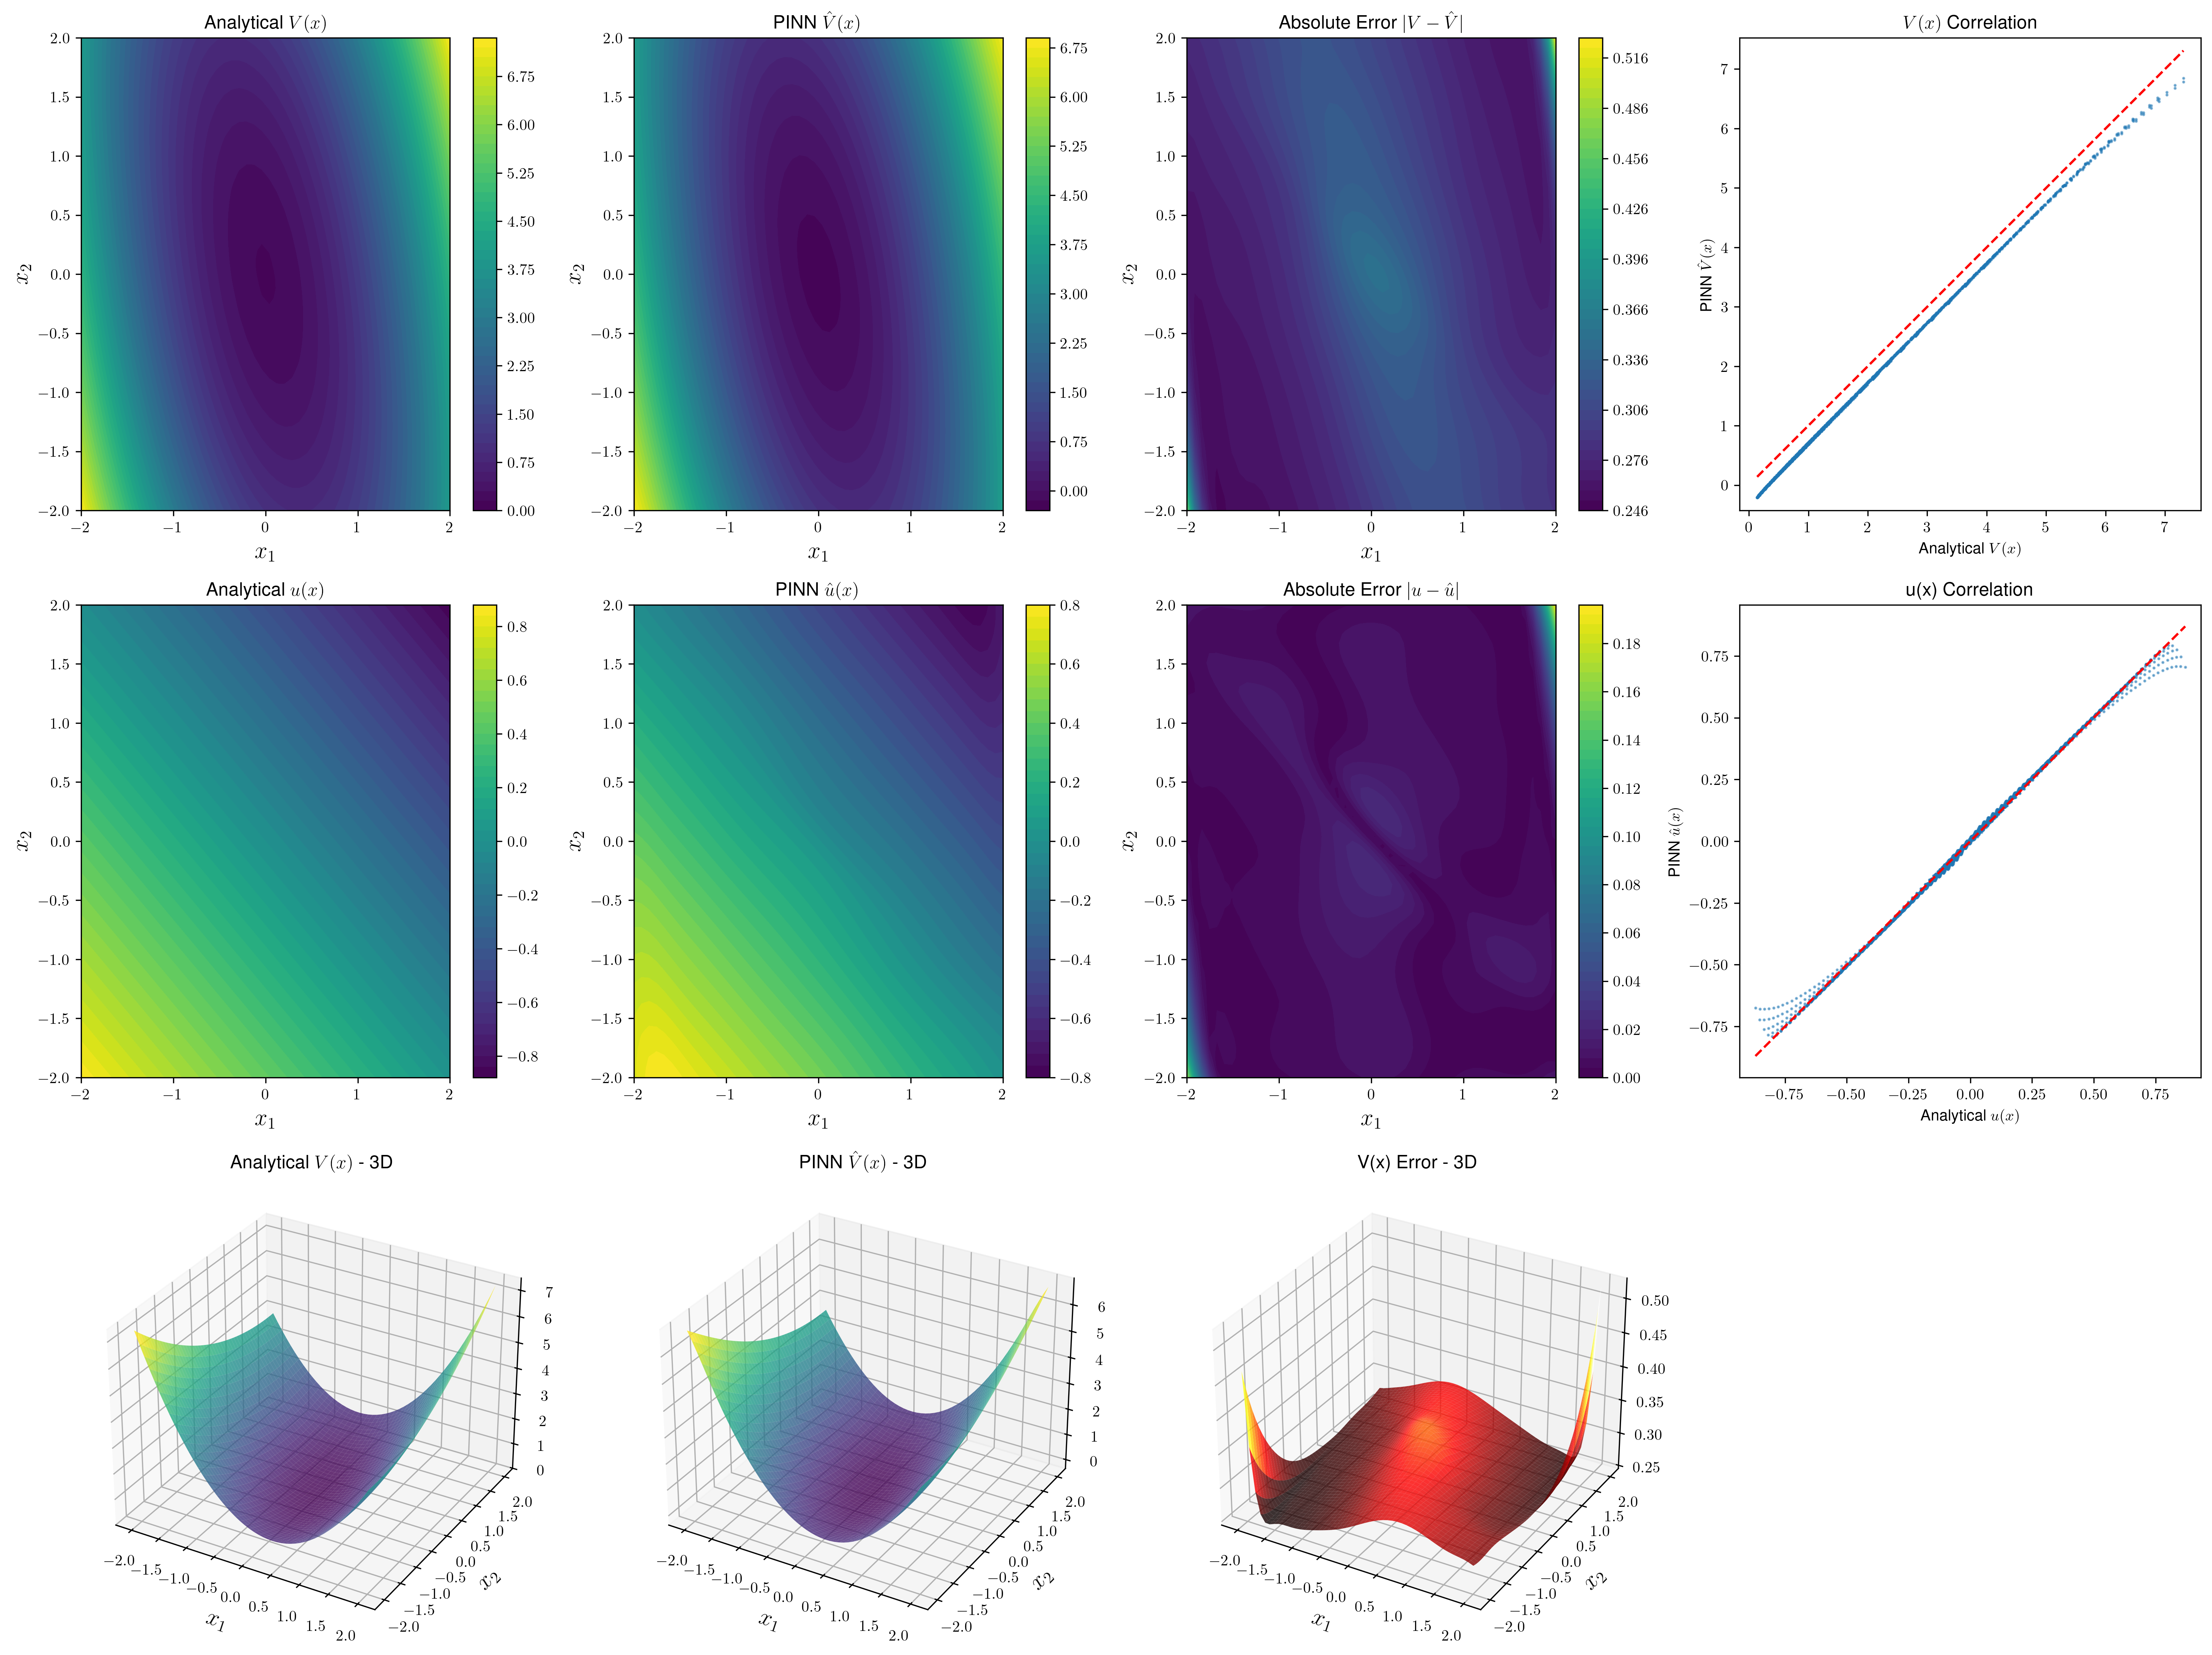

In [18]:
# From the solved CARE analytically, we have that
P_analytical = P
K_analytical = K
c_analytical = c

# Compare solutions
print("\nComparing PINN with Analytical Solution...")
comparison_results = compare_solutions(model, P_analytical, c_analytical, K_analytical)
metrics = compute_metrics(comparison_results)
plot_comparison(comparison_results)

## **2. Stochastic optimal stopping LQR**

Consider a continuous-time risk-sensitive LQR problem, in which dynamics of $x$ follows:

$$dx_t = (Ax_t + Bu_t)dt + Gdw_t$$

where $x_t \in \mathbb{R}^n$, $u_t \in \mathbb{R}^m$, $w_t$ is a standard $r$-dimensional Wiener process and $G \in \mathbb{R}^{n \times r}$.

The stochastic optimal stopping LQR problem is to minimize the cost function:

$$J(u, \tau) = \mathbb{E}\left[\int_0^\tau e^{-\rho t}\left(x(t)^TQx(t) + u(t)^TRu(t)\right)dt + e^{-\rho\tau}x(\tau)^TSx(\tau)\right]$$

by choosing optimal control $u_t$ and an optimal stopping time $\tau$. The value function $V(x)$ satisfies the stochastic HJB variational inequality:

$$\min\left\{\rho V(x) - \min_u\left[x^TQx + u^TRu + \nabla V(x)^T(Ax + Bu) + \frac{1}{2}\text{Tr}(GG^T\nabla^2V(x))\right], V(x) - x^TSx\right\} = 0$$

The solution to the above problem is:

$$V(x) = \begin{cases}
x^TPx, & x \in \text{ the continuation region } C = \mathbb{R}^m \setminus S \\
x^TSx, & x \in \text{ the stopping region } S
\end{cases}$$

This means that, for $x \in C$, apply $u^*(x)$, and for $x \in S$, stop immediately: $\tau = 0$.

In the continuation region $C$, the optimal control is linear:

$$u^*(x) = -R^{-1}B^TPx$$

and the matrix $P$ satisfies the stochastic Riccati equation:

$$A^TP + PA - PBR^{-1}B^TP + Q - \rho P + PGG^TP = 0$$

The stopping region is given by:

$$S = \{x \in \mathbb{R}^n : x^TPx \leq x^TSx\}$$

The boundary of $S$ which solves the equation $x^TPx \leq x^TSx$ is called the stopping boundary. Since the stopping boundary is a function of $x$, we denote it by $b(x)$.

Consider the problem with parameters:

$$\rho = 0.1, \quad A = \begin{bmatrix}0 & 1 \\ -2 & -3\end{bmatrix}, \quad B = \begin{bmatrix}0 \\ 1\end{bmatrix}, \quad G = \begin{bmatrix}0.1 & 0 \\ 0 & 0.1\end{bmatrix}, \quad Q = \begin{bmatrix}1 & 0 \\ 0 & 1\end{bmatrix}, \quad R = [1]$$

and $S = I_2$, solve the following problem:

**(a)** Use the analytical result above to compute the value function $V(x)$, optimal control $u$, and the stopping boundary $b(x)$.

To find the value function $V(x)$ we need to solve first the stochastic Riccati equation to obtain $P$

In [ ]:
# System parameters
rho = 0.1
A = np.array([[0, 1], [-2, -3]])
B = np.array([[0], [1]])
G = np.array([[0.1, 0], [0, 0.1]])
Q = np.array([[1, 0], [0, 1]])
R = np.array([[1]])
S = np.eye(2)  # S = I_2

GGt = G @ G.T
R_inv = np.linalg.inv(R)

# Solve Riccati equation

def solve_stochastic_riccati(A, B, R, Q, G, rho,
                            tol=1e-9, maxiter=50, verbose=False):
    '''Solves the stochastic Riccati equation iteratively
    Inputs: A, B, Q, G are numpy arrays; R is assumed symmetric posdef scalar/matrix
    '''
    n = A.shape[0]
    I = np.eye(n)
    A_discounted = A - 0.5 * rho * I

    # Initial guess: solve CARE ignoring the P GG^T P term
    try:
        Pk = solve_continuous_are(A_discounted, B, Q, R)
    except Exception:
        # fallback initial guess
        Pk = Q.copy()

    def F(P):
        return (A_discounted.T @ P + P @ A_discounted
                - P @ B @ np.linalg.inv(R) @ B.T @ P
                + Q + P @ G @ G.T @ P)

    for k in range(maxiter):
        Fk = F(Pk)
        err = norm(Fk, ord='fro')
        if verbose:
            print(f"iter {k}: ||F(Pk)||_F = {err:.3e}")
        if err < tol:
            print(f"Converged after {k + 1} iterations")
            return Pk

        # Build closed-loop matrix for linearization
        BRB = B @ np.linalg.inv(R) @ B.T   # B R^{-1} B^T
        Acl = A_discounted - BRB @ Pk + (G @ G.T) @ Pk

        # Solve Lyapunov: Acl^T Δ + Δ Acl = -F(Pk) 
        # scipy solver expects A X + X A^T = Q; we adapt by transposing
        # Solve (Acl^T) Δ + Δ (Acl) = -Fk  =>  (Acl) Δ^T + Δ^T (Acl)^T = -Fk^T
        # but we can use solve_continuous_lyapunov on Acl and right-hand side:
        # solve_continuous_lyapunov(Acl.T, -Fk) returns Δ
        try:
            Delta = solve_continuous_lyapunov(Acl.T, -Fk)
        except Exception as e:
            raise RuntimeError("Lyapunov solve failed in Newton step: " + str(e))

        Pk = Pk + Delta

    raise RuntimeError("Newton iteration did not converge within maxiter")

P = solve_stochastic_riccati(A, B, R, Q, G, rho, verbose=True)
P_analytical = P

In [ ]:
# We can check that indeed our solution is optimal:
A.T @ P + P @ A - P @ B @ R_inv @ B.T @ P + Q - rho * P + P @ GGt @ P

We know that in the continuation region $C$, our optimal solution is given by

$$u^*(x) = -R^{-1}B^TPx$$

which is equivalent to

$$u^*(x) = -Kx$$

In [ ]:
K = np.linalg.inv(R) @ B.T @ P
K

In [ ]:
# Stopping region: {x: xᵀPx ≤ xᵀSx} = {x: xᵀ(P-S)x ≤ 0}
P_minus_S = P - S
print(f"P - S = \n{P_minus_S}")

eigvals = np.linalg.eigvals(P_minus_S)
print(f"Eigenvalues of (P-S): {eigvals}")

In [ ]:
def exact_solution(P_analytical, S, K_analytical, x_range=(-2, 2), grid_points=50):
    """Find analytical solution for each point in the domain"""
    
    # Create test grid
    x1 = np.linspace(x_range[0], x_range[1], grid_points)
    x2 = np.linspace(x_range[0], x_range[1], grid_points)
    
    # Make a grid of X1 and X2 coordinates
    X1, X2 = np.meshgrid(x1, x2, indexing='ij')
    # Merge both grids in coordinate pairs, shape = (2500, 2) = (gridpoints², 2)
    x_test_np = np.stack([X1.ravel(), X2.ravel()], axis=1)

    # Analytical solutions and continuation / stopping regions
    V_analytical = []
    continuation_region = []
    stopping_region = []
    
    for x in x_test_np:
        # Check if the point is in the stopping region
        if (x.T @ (P_analytical - S) @ x <= 0):
            V_analytical.append(x.T @ S @ x)
            stopping_region.append(x)
        # Continuation region
        else:
            V_analytical.append(x.T @ P_analytical @ x)
            continuation_region.append(x)
            
    u_analytical = -K_analytical @ x_test_np.T  # u = -Kx
    
    # Reshape for plotting
    V_analytical_grid = np.array(V_analytical).reshape(grid_points, grid_points)
    u_analytical_grid = np.array(u_analytical).reshape(1, grid_points, grid_points)
    
    return {
        'x1': X1, 'x2': X2,
        'V_analytical': V_analytical_grid, 'u_analytical': u_analytical_grid,
        'Regions': [continuation_region, stopping_region]
    }

def plot_solution(exact_results, P, S):
    """Create comprehensive comparison plots"""
    
    X1, X2 = exact_results['x1'], exact_results['x2']
    
    fig = plt.figure(figsize=(10, 10))
    
    # 1. Value Function Comparison
    
    # Analytical solution for V
    plt.subplot(2, 2, 1)
    contour = plt.contourf(X1, X2, exact_results['V_analytical'], levels=50)
    plt.colorbar(contour)
    plt.xlabel(r'$x_1$', fontsize=15)
    plt.ylabel(r'$x_2$', fontsize=15)
    plt.title(r'Analytical $V(x)$')
    
    # 2. Control Policy Comparison
    
    # Analytical solution for u
    plt.subplot(2, 2, 2)
    contour = plt.contourf(X1, X2, exact_results['u_analytical'][0], levels=50)
    plt.colorbar(contour)
    plt.xlabel(r'$x_1$', fontsize=15)
    plt.ylabel(r'$x_2$', fontsize=15)
    plt.title(r'Analytical $u(x)$')
    
    # 3. 3D Surface Plots
    
    # 3D plot V(x) analytical
    ax = fig.add_subplot(2, 2, 3, projection='3d')
    ax.plot_surface(X1, X2, exact_results['V_analytical'], cmap='viridis', alpha=0.8)
    ax.set_title(r'Analytical $V(x)$ - 3D')
    ax.set_xlabel(r'$x_1$', fontsize=15)
    ax.set_ylabel(r'$x_2$', fontsize=15)
    
    # 4. Decision region
    
    ax = fig.add_subplot(2, 2, 4)
    stop_points = np.array(exact_results['Regions'][0])
    continue_points = np.array(exact_results['Regions'][1])

    # Scatter plot the regions
    ax.scatter(stop_points[:, 0], stop_points[:, 1], 
            c='orange', s=1, alpha=1, label='Stop', marker='o')
    ax.scatter(continue_points[:, 0], continue_points[:, 1], 
            c='lightblue', s=1, alpha=1, label='Continue')


    ax.set_title('Orange: Stop, Blue: Continue')
    ax.set_xlabel(r'$x_1$', fontsize=15)
    ax.set_ylabel(r'$x_2$', fontsize=15)
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.grid(True, alpha=0.2)
    
    plt.tight_layout()
    plt.show()
    
    return None

In [ ]:
exact_solution = exact_solution(P, S, K)
plot_solution(exact_solution, P, S)

**(b)** Use the PINN method to solve the obtained equation for $V(x)$, $u$ and $b(x)$. Denote your solution by $\hat{V}(x)$ and $\hat{u}(x)$. (Hint: Construct two networks for $V(x)$ and $b(x)$, respectively).

In [ ]:
# Convert to PyTorch tensors
A_tensor = torch.tensor(A, dtype=torch.float32, device=device)
B_tensor = torch.tensor(B, dtype=torch.float32, device=device)
G_tensor = torch.tensor(G, dtype=torch.float32, device=device)
Q_tensor = torch.tensor(Q, dtype=torch.float32, device=device)
R_tensor = torch.tensor(R, dtype=torch.float32, device=device)
S_tensor = torch.tensor(S, dtype=torch.float32, device=device)
R_inv = torch.linalg.inv(R_tensor)
GGt = G_tensor @ G_tensor.T
B_Rinv_BT = B_tensor @ R_inv @ B_tensor.T

class ValueNetwork_Stopping(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=128, num_layers=5):
        super(ValueNetwork_Stopping, self).__init__()
        
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.Tanh())
        
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.Tanh())
        
        layers.append(nn.Linear(hidden_dim, 1))
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

class BoundaryNetwork(nn.Module):
    """Network to approximate the stopping boundary function b(x)"""
    def __init__(self, input_dim=2, hidden_dim=64, num_layers=3):
        super(BoundaryNetwork, self).__init__()
        
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.Tanh())
        
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.Tanh())
        
        layers.append(nn.Linear(hidden_dim, 1))
        layers.append(nn.Sigmoid())  # Output between 0 and 1
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

class OptimalStoppingPINN:
    def __init__(self, V_net, b_net, A, B, Q, R_inv, GGt, S, rho):
        self.V_net = V_net
        self.b_net = b_net
        self.A = A
        self.B = B
        self.Q = Q
        self.R_inv = R_inv
        self.GGt = GGt
        self.S = S
        self.rho = rho
        self.B_Rinv_BT = B @ R_inv @ B.T
 
    def compute_gradients(self, x):
        """Compute V, ∇V, and ∇²V"""
        x.requires_grad_(True)
        V = self.V_net(x)
        
        # Compute ∇V(x) (gradient of V with respect to x)
        grad_V = torch.autograd.grad(V.sum(), x, create_graph=True)[0]
        
        # Compute ∇²V (Hessian)
        hessian_V = []
        for i in range(x.shape[1]):
            grad_V_i = grad_V[:, i]    # i-th component of the gradient
            hessian_i = torch.autograd.grad(grad_V_i.sum(), x, create_graph=True)[0]
            hessian_V.append(hessian_i.unsqueeze(1))

        # Stack to get full Hessian: [batch_size, n, n]
        hessian_V = torch.cat(hessian_V, dim=1)
        
        return V, grad_V, hessian_V
    
    def physics_loss(self, x):
        """HJB variational inequality loss"""
        x.requires_grad_(True)
        V, grad_V, hessian_V = self.compute_gradients(x)
        
        # Compute S(x) = xᵀSx
        S_x = torch.einsum('bi,ij,bj->b', x, self.S, x).unsqueeze(1)
        
        # HJB term in continuation region
        term1 = torch.einsum('bi,ij,bj->b', x, self.Q, x).unsqueeze(1)  # xᵀQx
        term2 = torch.einsum('bi,ij,bj->b', grad_V, self.A, x).unsqueeze(1) # ∇VᵀAx
        
        # GGᵀ∇²V for each sample in batch
        GGt_hessian = torch.einsum('ij,bjk->bik', self.GGt, hessian_V)

        # Sum of diagonal elements for each batch (Trace)
        trace_GGt_hessian = torch.einsum('bii->b', GGt_hessian).unsqueeze(1)
        term3 = 0.5 * trace_GGt_hessian  # ½tr(GGᵀ∇²V)
        
        # Nonlinear term with stochastic part: -¼(∇Vᵀ B R⁻¹ Bᵀ ∇V)
        quad_form_control = torch.einsum('bi,ij,bj->b', grad_V, self.B_Rinv_BT, grad_V).unsqueeze(1)
        term4 = -0.25 * quad_form_control
        
        HJB_operator = self.rho * V - (term1 + term2 + term3 + term4)
        
        # Variational inequality: min{HJB_operator, V - xᵀSx} = 0
        # This means both terms should be ≥ 0 and at least one = 0
        
        continuation_loss = torch.mean(torch.relu(-HJB_operator)**2)  # Should be ≥ 0
        stopping_loss = torch.mean(torch.relu(-(V - S_x))**2)  # Should be ≥ 0
        complementarity_loss = torch.mean((HJB_operator * (V - S_x))**2)  # Should be ≈ 0
        
        total_loss = continuation_loss + stopping_loss + complementarity_loss
        
        return total_loss
    
    def boundary_consistency_loss(self, x):
        """Ensure boundary network is consistent with value function"""
        V = self.V_net(x)
        S_x = torch.einsum('bi,ij,bj->b', x, self.S, x).unsqueeze(1)
        b = self.b_net(x)   # b ≈ 1 in stopping region, ≈ 0 in continuation region
        
        # In stopping region (b ≈ 1), V should be close to S_x
        stopping_loss = torch.mean(b * (V - S_x)**2)
        
        # In continuation region (b ≈ 0), HJB equation should hold exactly
        x_cont = x.clone().requires_grad_(True)
        V_cont, grad_V_cont, hessian_cont = self.compute_gradients(x_cont)
        
        # Compute HJB residual for continuation region
        term1_cont = torch.einsum('bi,ij,bj->b', x_cont, self.Q, x_cont).unsqueeze(1)
        term2_cont = torch.einsum('bi,ij,bj->b', grad_V_cont, self.A, x_cont).unsqueeze(1)
        GGt_hessian = torch.einsum('ij,bjk->bik', self.GGt, hessian_cont)
        term3_cont = 0.5 * torch.einsum('bii->b', GGt_hessian).unsqueeze(1)
        quad_form_control_cont = -0.25 * torch.einsum('bi,ij,bj->b', grad_V_cont, self.B_Rinv_BT, grad_V_cont).unsqueeze(1)
        
        HJB_cont = self.rho * V_cont - (term1_cont + term2_cont + term3_cont + quad_form_control_cont)
        continuation_region_loss = torch.mean((1 - b) * HJB_cont**2)
        
        # Encourage binary behavior in boundary network
        binary_loss = torch.mean(b * (1 - b))  # Encourage b to be near 0 or 1
        
        return stopping_loss + continuation_region_loss + 0.1 * binary_loss

Training 

In [ ]:
def train_optimal_stopping_pinn(pinn, epochs=5000, print_every=500):
    """Train the optimal stopping PINN"""
    
    # Generate training data
    def generate_training_data(num_points=500):
        # Sample more points near expected boundary
        radial = torch.rand(num_points) * 3  # Up to radius 3
        angle = torch.rand(num_points) * 2 * torch.pi
        x1 = radial * torch.cos(angle)
        x2 = radial * torch.sin(angle)
        return torch.stack([x1, x2], dim=1).to(device)
    
    optimizer_V = torch.optim.Adam(pinn.V_net.parameters(), lr=1e-3)
    optimizer_b = torch.optim.Adam(pinn.b_net.parameters(), lr=1e-3)
    #scheduler_V = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_V, patience=1000, factor=0.5)
    #scheduler_b = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_b, patience=1000, factor=0.5)
    
    losses = []
    
    for epoch in range(epochs):
        x_domain = generate_training_data()
        
        # Train value network
        optimizer_V.zero_grad()
        loss_physics = pinn.physics_loss(x_domain)
        loss_physics.backward()
        optimizer_V.step()
        #scheduler_V.step(loss_physics)
        
        # Train boundary network
        optimizer_b.zero_grad()
        loss_boundary = pinn.boundary_consistency_loss(x_domain)
        loss_boundary.backward()
        optimizer_b.step()
        #scheduler_b.step(loss_boundary)
        
        total_loss = loss_physics + loss_boundary
        losses.append(total_loss.item())
        
        if epoch % print_every == 0:
            current_lr_V = optimizer_V.param_groups[0]['lr']
            current_lr_b = optimizer_b.param_groups[0]['lr']
            print(f'Epoch {epoch}, Total Loss: {total_loss.item():.6f}, '
                  f'Physics: {loss_physics.item():.6f}, Boundary: {loss_boundary.item():.6f}, '
                  f'LR_V: {current_lr_V:.2e}, LR_b: {current_lr_b:.2e}')
    
    return losses

# Initialize and train
V_net = ValueNetwork_Stopping().to(device)
b_net = BoundaryNetwork().to(device)
pinn = OptimalStoppingPINN(V_net, b_net, A_tensor, B_tensor, Q_tensor, 
                          R_inv, GGt, S_tensor, rho)

print("Training Optimal Stopping PINN...")
losses = train_optimal_stopping_pinn(pinn)

In [ ]:
def compare_optimal_stopping_solutions(V_net, b_net, P_analytical, S, x_range=(-3, 3), grid_points=100):
    """Compare PINN with analytical solution"""
    
    # Create test grid
    x1 = np.linspace(x_range[0], x_range[1], grid_points)
    x2 = np.linspace(x_range[0], x_range[1], grid_points)
    X1, X2 = np.meshgrid(x1, x2, indexing='ij')
    x_test_np = np.stack([X1.ravel(), X2.ravel()], axis=1)
    x_test_torch = torch.tensor(x_test_np, dtype=torch.float32, device=device)
    
    # Analytical solutions
    V_analytical = np.array([x.T @ P_analytical @ x if x.T @ (P_analytical - S) @ x > 0 
                           else x.T @ S @ x for x in x_test_np])
    
    region_analytical = np.array([1 if x.T @ (P_analytical - S) @ x > 0 else 0 
                                for x in x_test_np])  # 1 = continue, 0 = stop
    
    # PINN predictions
    with torch.no_grad():
        V_pinn = V_net(x_test_torch).cpu().numpy().flatten()
        b_pinn = b_net(x_test_torch).cpu().numpy().flatten()
        region_pinn = (b_pinn < 0.5).astype(int)  # b ~ 0: continue, b ~ 1: stop
    
    # Reshape for plotting
    V_analytical_grid = V_analytical.reshape(grid_points, grid_points)
    V_pinn_grid = V_pinn.reshape(grid_points, grid_points)
    region_analytical_grid = region_analytical.reshape(grid_points, grid_points)
    region_pinn_grid = region_pinn.reshape(grid_points, grid_points)
    
    # Compute errors
    V_error = np.abs(V_pinn - V_analytical)
    region_accuracy = np.mean(region_pinn == region_analytical)
    
    print(f"Region classification accuracy: {region_accuracy:.4f}")
    print(f"V(x) MAE: {np.mean(V_error):.6f}")
    print(f"V(x) Max Error: {np.max(V_error):.6f}")
    
    return {
        'X1': X1, 'X2': X2,
        'V_analytical': V_analytical_grid, 'V_pinn': V_pinn_grid,
        'region_analytical': region_analytical_grid, 'region_pinn': region_pinn_grid,
        'V_error': V_error.reshape(grid_points, grid_points)
    }

In [ ]:
def analyze_special_cases():
    """Explain why we stop immediately or never stop for special S matrices"""
    
    S_stop = np.array([[2.1482, 0.2102], [0.2102, 1.2246]])
    S_never = np.array([[0.1482, 0.2102], [0.2102, -0.7754]])
    
    print("=== Analysis of Special Cases ===")
    
    # For S_stop: Check if P - S is negative definite
    P_minus_S_stop = P_analytical - S_stop
    eigvals_stop = np.linalg.eigvals(P_minus_S_stop)
    print(f"S_stop case - Eigenvalues of (P-S): {eigvals_stop}")
    print("Interpretation: Both eigenvalues are NEGATIVE → P-S is negative definite")
    print("→ xᵀ(P-S)x ≤ 0 for ALL x → Entire space is stopping region")
    print("→ Optimal to stop immediately everywhere")
    
    print("\n" + "="*50 + "\n")
    
    # For S_never: Check if P - S is positive definite  
    P_minus_S_never = P_analytical - S_never
    eigvals_never = np.linalg.eigvals(P_minus_S_never)
    print(f"S_never case - Eigenvalues of (P-S): {eigvals_never}")
    print("Interpretation: Both eigenvalues are POSITIVE → P-S is positive definite")
    print("→ xᵀ(P-S)x ≥ 0 for ALL x → Entire space is continuation region") 
    print("→ Never optimal to stop")

In [ ]:
# Now run the comparison with PINN results
print("\n=== COMPARING PINN WITH ANALYTICAL SOLUTION ===")
comparison_results = compare_optimal_stopping_solutions(V_net, b_net, P, S)

# Create comprehensive comparison plots
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20, 15))

# 1. Value Function Comparison
plt.subplot(3, 4, 1)
contour = plt.contourf(comparison_results['X1'], comparison_results['X2'], 
                      comparison_results['V_analytical'], levels=50)
plt.colorbar(contour)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Analytical V(x)')
plt.axis('equal')

plt.subplot(3, 4, 2)
contour = plt.contourf(comparison_results['X1'], comparison_results['X2'], 
                      comparison_results['V_pinn'], levels=50)
plt.colorbar(contour)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('PINN V(x)')
plt.axis('equal')

plt.subplot(3, 4, 3)
contour = plt.contourf(comparison_results['X1'], comparison_results['X2'], 
                      comparison_results['V_error'], levels=50)
plt.colorbar(contour)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Absolute Error |V_PINN - V_analytic|')
plt.axis('equal')

plt.subplot(3, 4, 4)
# Scatter plot of V_analytical vs V_pinn
plt.scatter(comparison_results['V_analytical'].ravel(), 
           comparison_results['V_pinn'].ravel(), alpha=0.3, s=1)
min_val = min(comparison_results['V_analytical'].min(), comparison_results['V_pinn'].min())
max_val = max(comparison_results['V_analytical'].max(), comparison_results['V_pinn'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
plt.xlabel('Analytical V(x)')
plt.ylabel('PINN V(x)')
plt.title('V(x) Correlation')
plt.axis('equal')

# 2. Region Classification Comparison
plt.subplot(3, 4, 5)
plt.contourf(comparison_results['X1'], comparison_results['X2'], 
            comparison_results['region_analytical'], levels=2, cmap='coolwarm')
plt.colorbar(ticks=[0, 1])
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Analytical Regions\n(0=Stop, 1=Continue)')
plt.axis('equal')

plt.subplot(3, 4, 6)
plt.contourf(comparison_results['X1'], comparison_results['X2'], 
            comparison_results['region_pinn'], levels=2, cmap='coolwarm')
plt.colorbar(ticks=[0, 1])
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('PINN Regions\n(0=Stop, 1=Continue)')
plt.axis('equal')

# 3. Stopping Boundary
plt.subplot(3, 4, 7)
# Plot the analytical stopping boundary (where xᵀ(P-S)x = 0)
from matplotlib.colors import ListedColormap
cmap_binary = ListedColormap(['red', 'blue'])
plt.contourf(comparison_results['X1'], comparison_results['X2'], 
            comparison_results['region_analytical'], levels=2, cmap=cmap_binary, alpha=0.3)
# Overlay contour where xᵀ(P-S)x = 0
boundary_contour = plt.contour(comparison_results['X1'], comparison_results['X2'], 
                              comparison_results['region_analytical'], 
                              levels=[0.5], colors='black', linewidths=2)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Stopping Boundary\n(Red=Stop, Blue=Continue)')
plt.axis('equal')

# 4. Training Convergence
plt.subplot(3, 4, 8)
plt.semilogy(losses)
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('PINN Training Convergence')
plt.grid(True)

# 5. 3D Surface Plots
ax = fig.add_subplot(3, 4, 9, projection='3d')
surf = ax.plot_surface(comparison_results['X1'], comparison_results['X2'], 
                      comparison_results['V_analytical'], cmap='viridis', alpha=0.8)
ax.set_title('Analytical V(x) - 3D')
ax.set_xlabel('x1')
ax.set_ylabel('x2')

ax = fig.add_subplot(3, 4, 10, projection='3d')
surf = ax.plot_surface(comparison_results['X1'], comparison_results['X2'], 
                      comparison_results['V_pinn'], cmap='viridis', alpha=0.8)
ax.set_title('PINN V(x) - 3D')
ax.set_xlabel('x1')
ax.set_ylabel('x2')

ax = fig.add_subplot(3, 4, 11, projection='3d')
surf = ax.plot_surface(comparison_results['X1'], comparison_results['X2'], 
                      comparison_results['V_error'], cmap='hot', alpha=0.8)
ax.set_title('V(x) Error - 3D')
ax.set_xlabel('x1')
ax.set_ylabel('x2')

plt.tight_layout()
plt.show()

# Print quantitative metrics
print("\n=== QUANTITATIVE COMPARISON METRICS ===")
V_analytical_flat = comparison_results['V_analytical'].ravel()
V_pinn_flat = comparison_results['V_pinn'].ravel()
V_error_flat = np.abs(V_pinn_flat - V_analytical_flat)

print(f"Value Function V(x):")
print(f"  MAE: {np.mean(V_error_flat):.6f}")
print(f"  RMSE: {np.sqrt(np.mean(V_error_flat**2)):.6f}")
print(f"  Max Error: {np.max(V_error_flat):.6f}")
print(f"  R² Score: {1 - np.sum(V_error_flat**2) / np.sum((V_analytical_flat - np.mean(V_analytical_flat))**2):.6f}")

region_accuracy = np.mean(comparison_results['region_pinn'].ravel() == comparison_results['region_analytical'].ravel())
print(f"Region Classification Accuracy: {region_accuracy:.4f}")

# Analyze the special cases for part (d)
print("\n=== ANALYSIS OF SPECIAL CASES (Part d) ===")
analyze_special_cases()

**(c)** Compare your results in (a) and (b).

**(d)** Explain why it is optimal to stop immediately at time 0 for

$$S = \begin{bmatrix}2.1482 & 0.2102 \\ 0.2102 & 1.2246\end{bmatrix}$$

and why it should never stop for

$$S = \begin{bmatrix}0.1482 & 0.2102 \\ 0.2102 & -0.7754\end{bmatrix}$$